<a href="https://colab.research.google.com/github/JoseADios/SemanticSearchPython/blob/main/SemanticSearch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto Final: Sistema de Búsqueda Semántica para Artículos Científicos
## Inteligencia Artificial
## Profesor Lizandro Ramírez

In [ ]:
# permisos para drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Intalacion de librerias

In [ ]:
!!pip install kaggle -q -U

['\x1b[?25l     \x1b━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\x1b \x1b0.0/82.7 kB\x1b \x1b?\x1b eta \x1b-:--:--\x1b',
 '\x1b[2K     \x1b━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\x1b \x1b82.7/82.7 kB\x1b \x1b2.2 MB/s\x1b eta \x1b0:00:00\x1b',
 '\x1b[?25h  Preparing metadata (setup.py) ... \x1b[?25l\x1b[?25hdone',
 '  Building wheel for kaggle (setup.py) ... \x1b[?25l\x1b[?25hdone']

In [ ]:
!pip install gensim spacy matplotlib transformers seaborn scikit-learn -q -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 35.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 53.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 45.4 MB/s eta 0:00:00


# Paso 1: Recoleccion de datos




## API KEY de Kaggle

In [ ]:
from google.colab import userdata
userdata.get('KAGGLE_API_KEY')

In [ ]:
!mkdir ~/.kaggle
!echo userdata.get('KAGGLE_API_KEY') > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d Cornell-University/arxiv
!echo "Y" | unzip arxiv.zip

## Conversion en CSV

In [ ]:
import pandas as pd

chunk_size = 10000  # Número de líneas por fragmento

df_list = []

# Leer el archivo en fragmentos
for chunk in pd.read_json('arxiv-metadata-oai-snapshot.json', lines=True, chunksize=chunk_size):
    df_list.append(chunk)

# Combinar todos los fragmentos
df = pd.concat(df_list, ignore_index=True)



In [ ]:
# Guardar el DataFrame combinado en un archivo CSV para futuras cargas más rápidas
df.to_csv('arxiv_metadata.csv', index=False)

In [ ]:
# crear carpeta ArxivDataset en drive
!mkdir /content/drive/MyDrive/ArxivDataset

# guardar el csv en drive
!cp arxiv_metadata.csv /content/drive/MyDrive/ArxivDataset/arxiv_metadata.csv

# Paso 2: Preprocesamiento de Datos

## Lectura del CSV, solo columnas necesarias

In [ ]:
import pandas as pd

# tamaño de la muestra
nrows = 1000

# obtener el csv solo con las columnas necesarias
df = pd.read_csv('/content/drive/MyDrive/ArxivDataset/arxiv_metadata.csv', nrows=nrows)[['id', 'title', 'abstract', 'authors']]

In [ ]:
# guardar df
df.to_csv('arxiv_metadata.csv', index=False)

In [ ]:
df.head()

,id,title,abstract,authors
0,704.0001,Calculation of prompt diphoton production cros...,A fully differential calculation in perturba...,"C. Bal\'azs, E. L. Berger, P. M. Nadolsky, C.-..."
1,704.0002,Sparsity-certifying Graph Decompositions,"We describe a new algorithm, the $(k,\ell)$-...",Ileana Streinu and Louis Theran
2,704.0003,The evolution of the Earth-Moon system based o...,The evolution of Earth-Moon system is descri...,Hongjun Pan
3,704.0004,A determinant of Stirling cycle numbers counts...,We show that a determinant of Stirling cycle...,David Callan
4,704.0005,From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...,In this paper we show how to compute the $\L...,Wael Abu-Shammala and Alberto Torchinsky


## 2.2 Preprocesamiento del texto


## Concatenar columnas

In [ ]:
import pandas as pd
import re

# Función para concatenar texto
def concatenate_text(row):
    return row['abstract'] + " \n " + row['authors']

chunk_size = 10000

# crear archivo concatenated_data.csv
with open('concatenated_data.csv', 'w') as f:
    f.write('id,title,text\n')


for chunk in pd.read_csv('arxiv_metadata.csv', chunksize=chunk_size):
    chunk['text'] = chunk.apply(concatenate_text, axis=1)
    chunk = chunk[['id','title','text']]
    chunk.to_csv('concatenated_data.csv', mode='a', header=False, index=False)

In [ ]:
import re

# Preprocesamiento: limpieza y normalización
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Elimina caracteres especiales
    return text

chunk_size = 10000

# crear archivo preprocessed_data.csv
with open('preprocessed_data.csv', 'w') as f:
    f.write('id,title,text\n')


for chunk in pd.read_csv('concatenated_data.csv', chunksize=chunk_size):
    chunk['text'] = chunk['text'].apply(preprocess_text)
    chunk.to_csv('preprocessed_data.csv', mode='a', header=False, index=False)

In [ ]:
df = pd.read_csv('preprocessed_data.csv')

df.head()

,id,title,text
0,704.0001,Calculation of prompt diphoton production cros...,calculation of prompt diphoton production cros...
1,704.0002,Sparsity-certifying Graph Decompositions,sparsitycertifying graph decompositions \n w...
2,704.0003,The evolution of the Earth-Moon system based o...,the evolution of the earthmoon system based on...
3,704.0004,A determinant of Stirling cycle numbers counts...,a determinant of stirling cycle numbers counts...
4,704.0005,From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...,from dyadic lambdaalpha to lambdaalpha \n in...


In [ ]:
# actualizar el csv en drive
!cp preprocessed_data.csv /content/drive/MyDrive/ArxivDataset/preprocessed_data.csv

## 2.3 Tokenizar los artículos

In [ ]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/ArxivDataset/preprocessed_data.csv')

df.to_csv('preprocessed_data_sample.csv', index=False)

In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch

# Cargar el modelo y el tokenizador
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')
model = AutoModel.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')

# Función para generar embeddings
def get_embeddings(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).cpu().numpy().flatten()

# Generar embeddings para los artículos
df['embeddings'] = df['text'].apply(lambda x: get_embeddings(x).tolist())


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

In [ ]:
# Guardar los embeddings para usarlos en búsquedas
df.to_pickle('arxiv_embeddings.pkl')

In [ ]:
# Cargar los embeddings
df = pd.read_pickle('arxiv_embeddings.pkl')

In [ ]:
# guardar los embbedings en drive
!cp arxiv_embeddings.pkl /content/drive/MyDrive/ArxivDataset/arxiv_embeddings.pkl

In [ ]:
import pandas as pd

# cargar el pkl en df
df = pd.read_pickle('/content/drive/MyDrive/ArxivDataset/arxiv_embeddings.pkl')

In [ ]:

df.head()

,id,title,text,embeddings
0,704.0001,Calculation of prompt diphoton production cros...,calculation of prompt diphoton production cros...,"[-0.28185367584228516, -0.03663534298539162, -..."
1,704.0002,Sparsity-certifying Graph Decompositions,sparsitycertifying graph decompositions \n w...,"[-0.01022761408239603, 0.09086540341377258, 0...."
2,704.0003,The evolution of the Earth-Moon system based o...,the evolution of the earthmoon system based on...,"[-0.05371815711259842, -0.05113563314080238, 0..."
3,704.0004,A determinant of Stirling cycle numbers counts...,a determinant of stirling cycle numbers counts...,"[-0.19588159024715424, -0.07151373475790024, -..."
4,704.0005,From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...,from dyadic lambdaalpha to lambdaalpha \n in...,"[-0.010646315291523933, -0.07939882576465607, ..."


## Cargar embbedings, funcion de busqueda y similitud

In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Cargar los embeddings
df = pd.read_pickle('arxiv_embeddings.pkl')

# Función de búsqueda y similitud
def search(query, df, top_k=5):
    query_embedding = get_embeddings(query)
    similarities = cosine_similarity([query_embedding], list(df['embeddings']))[0]
    df['similarity'] = similarities
    df['arxiv_url'] = 'https://arxiv.org/abs/0' + df['id'].astype(str)
    results = df.sort_values(by='similarity', ascending=False).head(top_k)
    return results


In [ ]:
# Busqueda

results = search('machine learning in healthcare', df)
results

,id,title,text,embeddings,similarity,arxiv_url
670,704.0671,Learning from compressed observations,learning from compressed observations \n the...,"[-0.2715001404285431, -0.05612117797136307, 0....",0.234590,https://arxiv.org/abs/0704.0671
610,704.0611,Modeling the field of laser welding melt pool ...,modeling the field of laser welding melt pool ...,"[-0.09170422703027725, -0.46209341287612915, 0...",0.226230,https://arxiv.org/abs/0704.0611
516,704.0517,Using decomposed household food acquisitions a...,using decomposed household food acquisitions a...,"[0.1323314756155014, 0.010626838542521, 0.0499...",0.206458,https://arxiv.org/abs/0704.0517
88,704.0089,A general approach to statistical modeling of ...,a general approach to statistical modeling of ...,"[-0.11621635407209396, -0.03177323937416077, 0...",0.179799,https://arxiv.org/abs/0704.0089
428,704.0429,"Quantitative Resolution to some ""Absolute Disc...",quantitative resolution to some absolute discr...,"[-0.10271847993135452, -0.07609805464744568, -...",0.159046,https://arxiv.org/abs/0704.0429


## Busqueda con FAISS

### Instalar libreria

In [ ]:
!pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 17.4 MB/s eta 0:00:00


### Funcion de busqueda FAISS

In [ ]:
import faiss
import numpy as np

# Cargar los embeddings (si no están cargados)
if 'embeddings' not in df.columns:
    df = pd.read_pickle('arxiv_embeddings.pkl')

def busqueda_faiss(consulta, df, top_k=5):

    # Asegurarse de que los embeddings son arrays de NumPy
    if not isinstance(df['embeddings'].iloc[0], np.ndarray):
        df['embeddings'] = df['embeddings'].apply(np.array)

    # Crear el índice FAISS
    index = faiss.IndexFlatIP(df['embeddings'].iloc[0].shape[0])
    index.add(np.stack(df['embeddings']))

    # Obtener el embedding de la consulta
    consulta_embedding = get_embeddings(consulta)

    # Realizar la búsqueda
    distances, indices = index.search(np.array([consulta_embedding]), k=top_k)

    # Obtener los resultados
    resultados = df.iloc[indices[0]]
    resultados['distancia_faiss'] = distances[0]
    resultados = resultados.sort_values('distancia_faiss', ascending=True)

    return resultados

### Mostrar resultados de la busqueda

In [ ]:
resultados = busqueda_faiss("machine learning in healthcare", df)
resultados

<ipython-input-48-ece3f5fe683b>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  resultados['distancia_faiss'] = distances[0]


,id,title,text,embeddings,similarity,arxiv_url,distancia_faiss
61,704.0062,On-line Viterbi Algorithm and Its Relationship...,online viterbi algorithm and its relationship ...,"[-0.34773048758506775, 0.014864018186926842, -...",0.146067,https://arxiv.org/abs/0704.0062,2.529559
107,704.0108,Reducing SAT to 2-SAT,reducing sat to sat \n description of a poly...,"[-0.1849863976240158, 0.4108324348926544, 0.05...",0.076621,https://arxiv.org/abs/0704.0108,3.083623
516,704.0517,Using decomposed household food acquisitions a...,using decomposed household food acquisitions a...,"[0.1323314756155014, 0.010626838542521, 0.0499...",0.206458,https://arxiv.org/abs/0704.0517,3.294989
670,704.0671,Learning from compressed observations,learning from compressed observations \n the...,"[-0.2715001404285431, -0.05612117797136307, 0....",0.234590,https://arxiv.org/abs/0704.0671,3.406372
610,704.0611,Modeling the field of laser welding melt pool ...,modeling the field of laser welding melt pool ...,"[-0.09170422703027725, -0.46209341287612915, 0...",0.226230,https://arxiv.org/abs/0704.0611,4.597477


# Visualización de Resultados con PCA

## Importacion de bibliotecas

In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Cargar el archivo .pkl
df = pd.read_pickle('arxiv_embeddings.pkl')

# Asegurarse de que los embeddings son arrays de una dimensión
df['embeddings'] = df['embeddings'].apply(np.array)


## Aplicar PCA

In [ ]:
# Extraer los embeddings
embeddings = np.array(df['embeddings'].tolist())

# Aplicar PCA
pca = PCA(n_components=2)  # Para 2D
embeddings_pca = pca.fit_transform(embeddings)

# Agregar los resultados de PCA al DataFrame
df['pca1'] = embeddings_pca[:, 0]
df['pca2'] = embeddings_pca[:, 1]


## Mostrar resultados

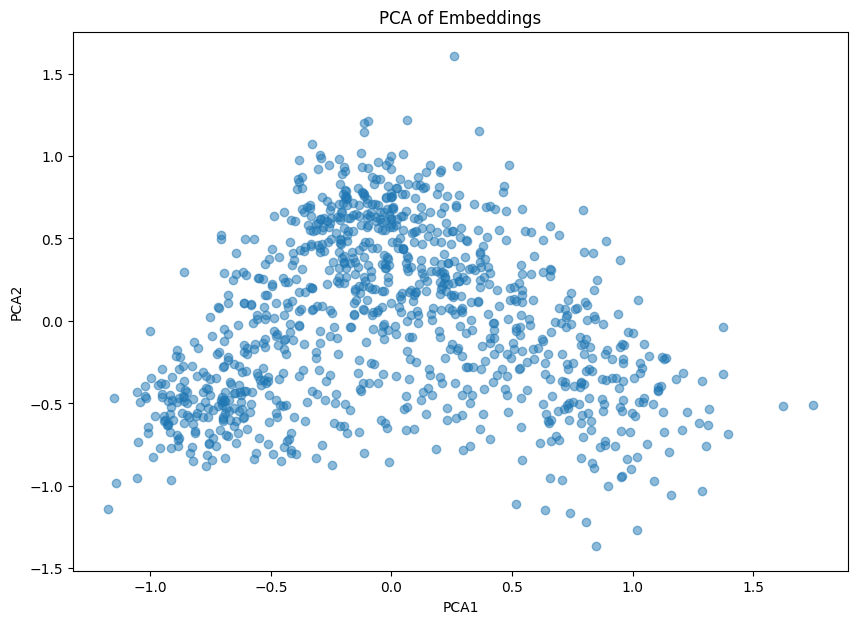

In [ ]:
# Visualización 2D
plt.figure(figsize=(10, 7))
plt.scatter(df['pca1'], df['pca2'], alpha=0.5)
plt.title('PCA of Embeddings')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.show()


## Visualizacion 3d

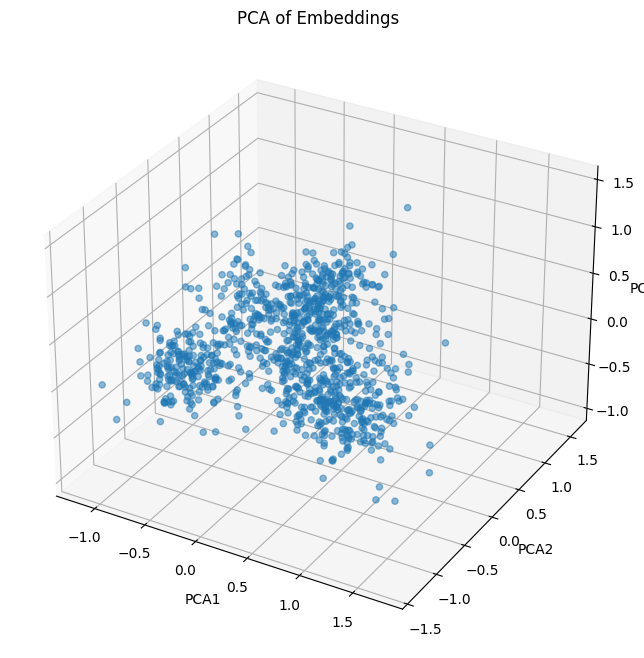

In [ ]:
# visualizacion 3d

from mpl_toolkits.mplot3d import Axes3D

# Aplicar PCA
pca = PCA(n_components=3)  # Para 3D
embeddings_pca = pca.fit_transform(embeddings)

# Crear una figura 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Graficar los puntos en el espacio 3D
ax.scatter(embeddings_pca[:, 0], embeddings_pca[:, 1], embeddings_pca[:, 2], alpha=0.5)

# Configurar etiquetas y título
ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_zlabel('PCA3')
ax.set_title('PCA of Embeddings')

# Mostrar la figura
plt.show()
